## Imports

In [84]:
import os
import warnings
warnings.filterwarnings("ignore") # remove some scikit-image warnings


from monai.apps import DecathlonDataset, TciaDataset
from monai.data import DataLoader
from monai.transforms import (
    LoadImageD,LoadImaged,
    EnsureChannelFirstD, EnsureChannelFirstd,
    Compose,
    OrientationD,
    OrientationD,
    Rotate90D, Rotate90,
    ResampleToMatchd
)
from monai.apps.tcia import TCIA_LABEL_DICT

import torch
import numpy as np
import random
import sys
from tqdm import tqdm
import pickle as pkl
import matplotlib.pyplot as plt
import cv2

## Hyperparamaters

In [85]:
crt_dir = os.getcwd()
datasets_path = f'{crt_dir}'

# DOWNLOAD_FLAG = not os.path.exists(datasets_path)
DOWNLOAD_FLAG = False

KEYS = ["image", "seg"]

In [86]:
# from glob import glob
os.path.isdir(datasets_path)

True

## PREPROCESSING TRANSFORMS

In [87]:
# To decode the specific labels we need LoadImage and ResampleToMatchd based on: https://docs.monai.io/en/stable/apps.html
# Not like in MSD, Data comes with patient alligned to the right wall (instead of left), from top of the lungs to the bottom
# We need to rotate on those axis to keep our models alligned with MSD
base_transform = Compose([LoadImaged(reader="PydicomReader", keys=["seg"], 
                                     label_dict=TCIA_LABEL_DICT["NSCLC-Radiomics"]),
                          EnsureChannelFirstd(keys = KEYS),
                          ResampleToMatchd(keys="image", key_dst="seg"),
                          Rotate90D(k=2, spatial_axes=(1, 2), keys = KEYS)
                         ])

In [88]:
# ### TRAINING DATA ###
train_name = 'training' # From Monai: ['training', 'validation', 'test']
# # train_dataset = DecathlonDataset(root_dir = datasets_path,
# #                         task = "Task06_Lung", section = train_name,
# #                         transform = base_transform, download = DOWNLOAD_FLAG)
train_dataset = TciaDataset(root_dir = datasets_path, section = train_name, download = DOWNLOAD_FLAG,
                           collection = "NSCLC-Radiomics", transform = ())

In [89]:
train_dataset[0]

{'image': metatensor([[[-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
          [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
          [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
          ...,
          [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
          [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
          [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.]],
 
         [[-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
          [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
          [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
          ...,
          [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
          [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
          [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.]],
 
         [[-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
          [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
          [-1024., -1024., 

In [90]:
tuple_pair = base_transform(train_dataset[0])

c = tuple_pair['image']

c.shape, c.min(), c.max()

(torch.Size([1, 512, 512, 118]), metatensor(-1024.), metatensor(3070.))

In [91]:
d = tuple_pair['seg']

d.shape, d.min(), d.max()

(torch.Size([7, 512, 512, 118]), metatensor(0.), metatensor(1.))

11 11


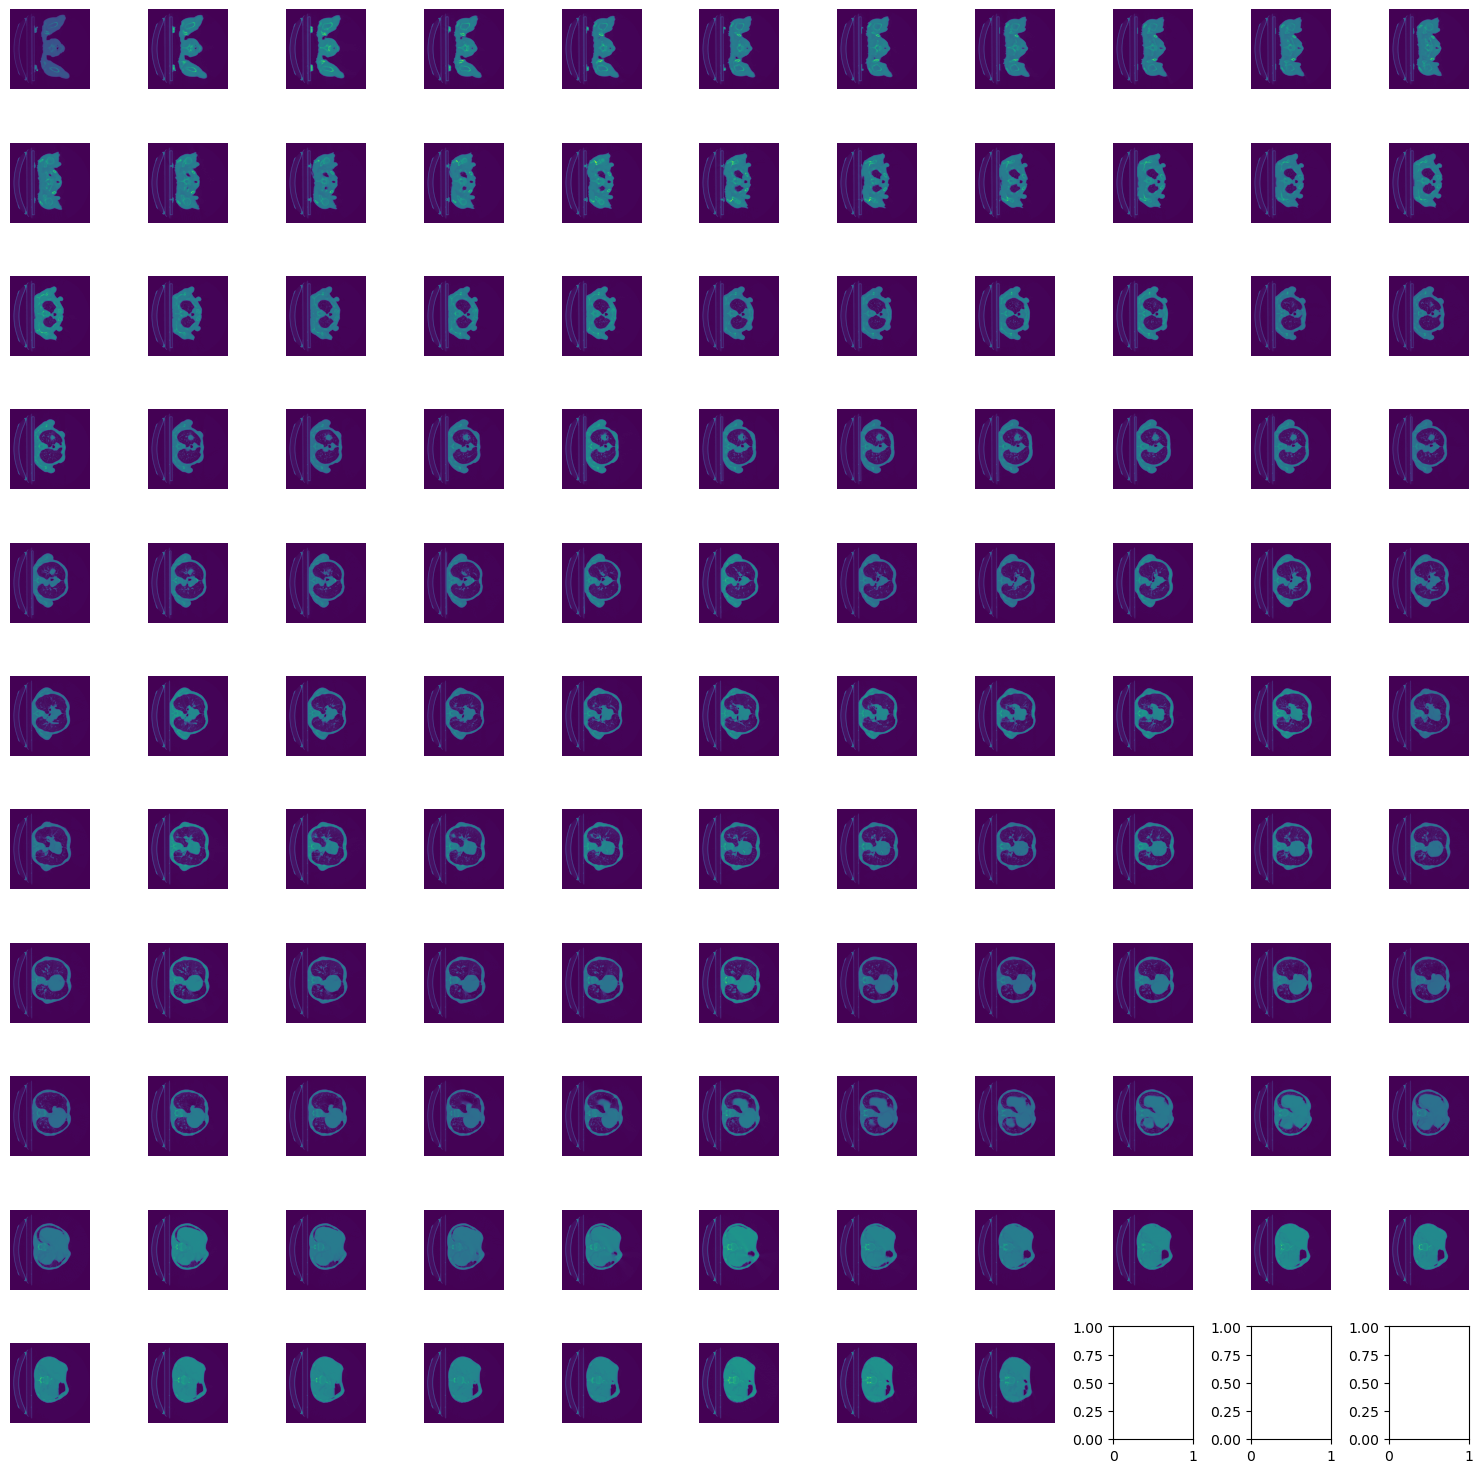

In [92]:
def plot_large_grid(vect):
    length = vect.shape[-1]

    rows = int(np.sqrt(length)) + 1
    cols = int(length / rows) + 1
    
    print(rows, cols)
    
    
    fig, ax = plt.subplots(rows, cols)

    fig.set_figheight(15)
    fig.set_figwidth(15)

    break_flag = False

    for i in range(rows):
        if break_flag:
            break

        for j in range(cols):
            crt_idx = cols*i + j 
            if crt_idx >= length:
#                 print(crt_idx)
#                 print(i, j)
                break_flag = True
                break

            ax[i, j].imshow(vect[0, ..., crt_idx])
            ax[i, j].axis("off")

    plt.tight_layout()        
    plt.show()

plot_large_grid(c)

In [108]:
labels = tuple_pair['seg'][1, ...].unsqueeze(0)
print(labels.shape)

torch.Size([1, 512, 512, 118])


In [109]:

def get_first_tumorous_slice(patient):
    last_dim = patient.shape[-1]
        
    for i in range(last_dim):
        mask = patient[0,..., i].sum()
        if mask > 0:
            return i
    
    raise Exception("Patient does not have tumorous slices") 
    
    
def get_last_tumorous_slice(patient):
    last_dim = patient.shape[-1]
        
    for i in range(last_dim):
        mask = patient[0,..., last_dim - i - 1].sum()
        if mask > 0:
            return last_dim - i - 1
    
    raise Exception("Patient does not have tumorous slices") 

def get_start_stop_tumor(patient):
    
    start, stop = get_first_tumorous_slice(patient), get_last_tumorous_slice(patient)

    return start, stop

11 11


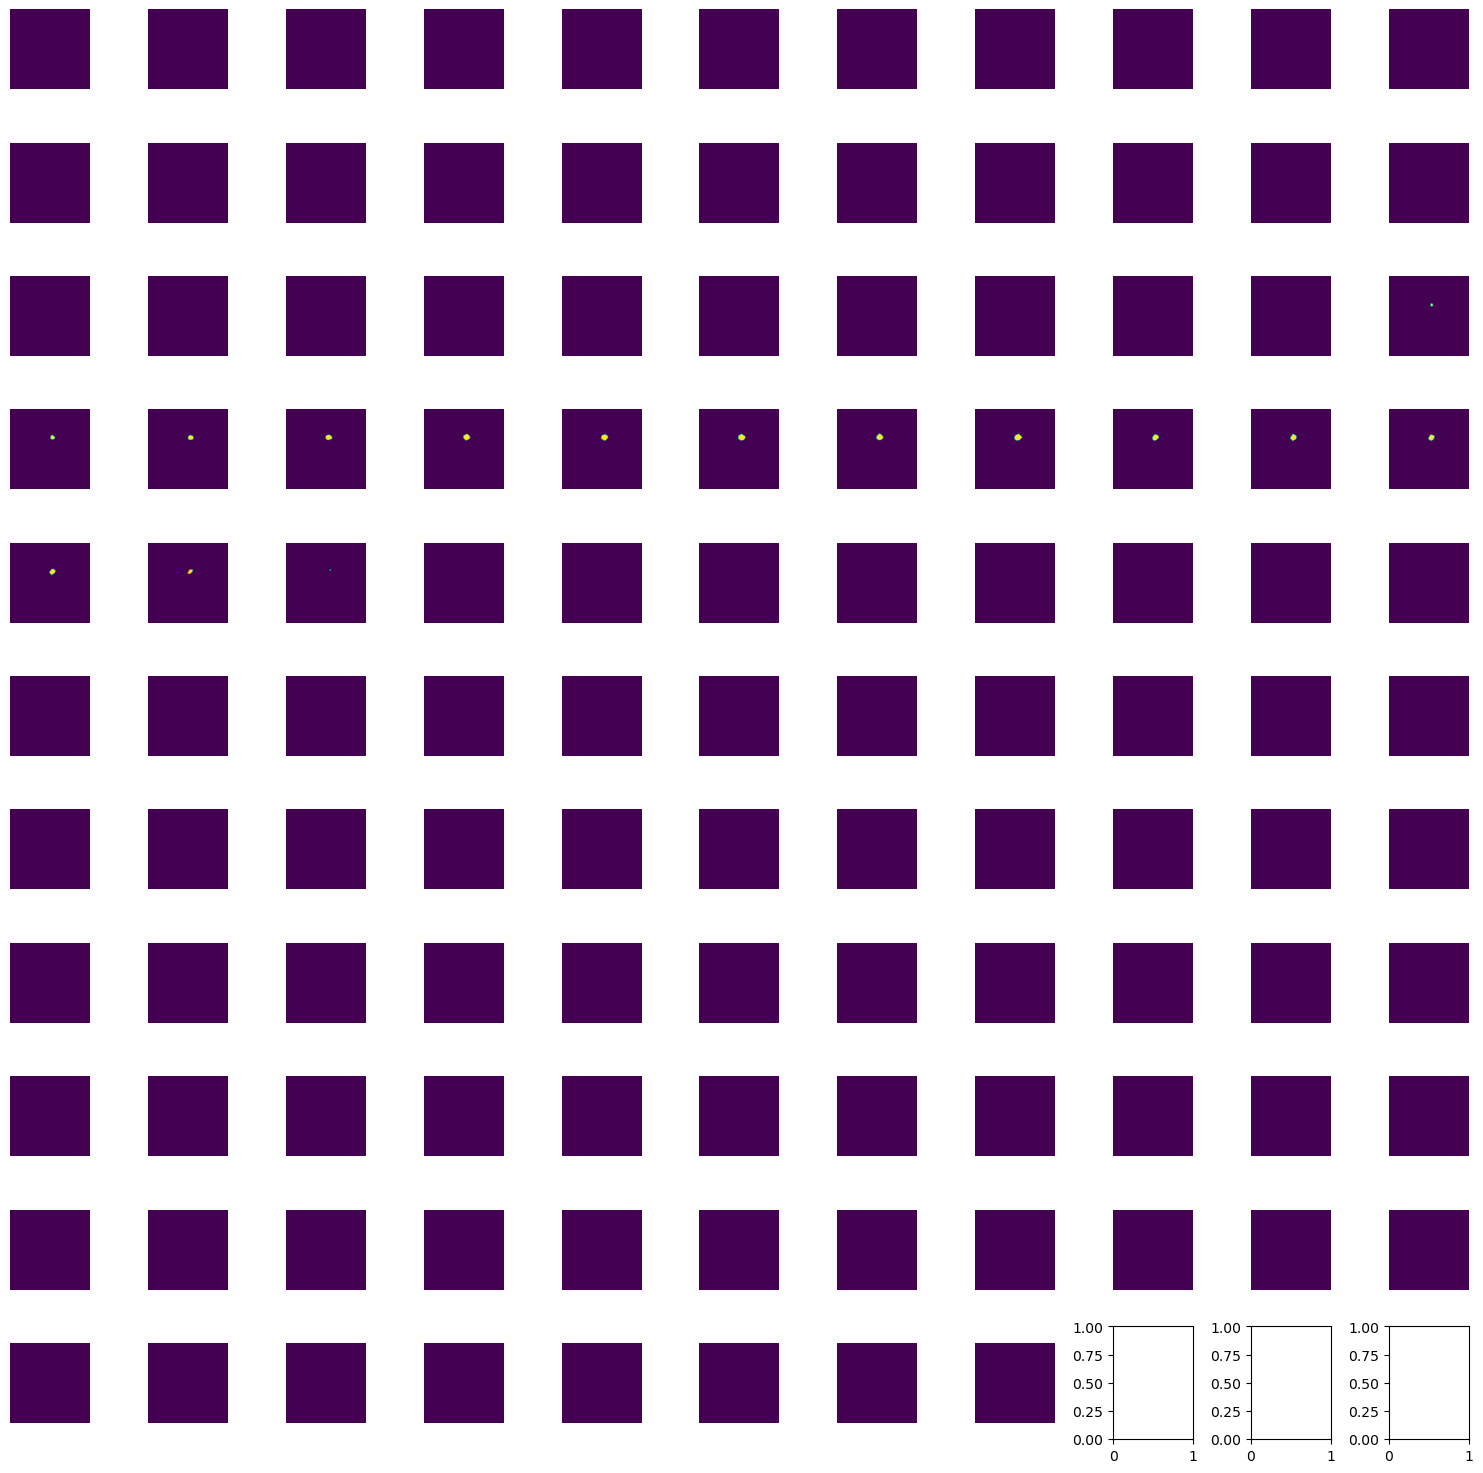

In [110]:
plot_large_grid(labels)

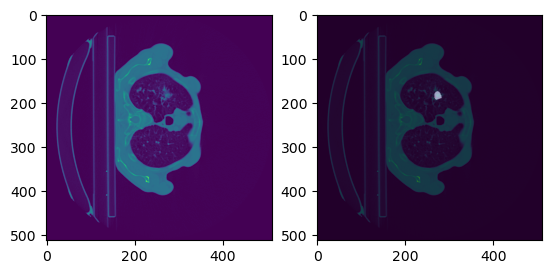

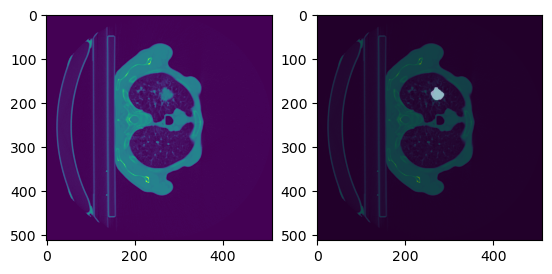

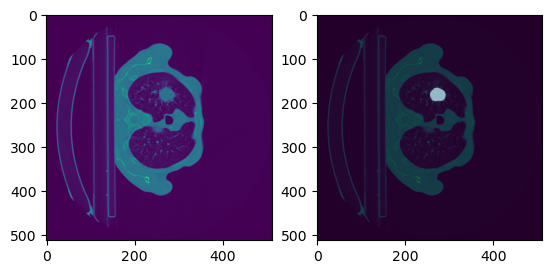

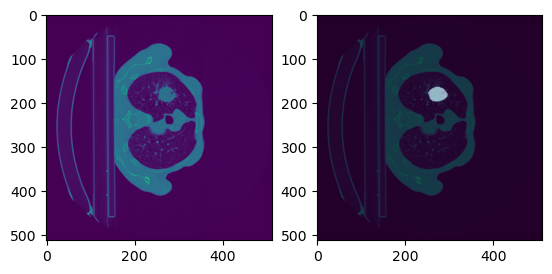

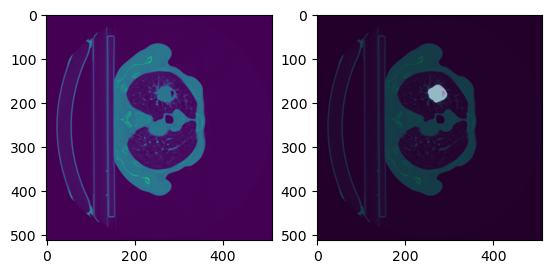

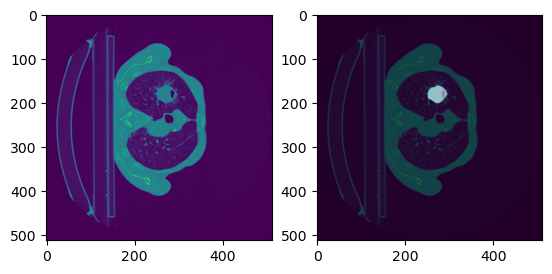

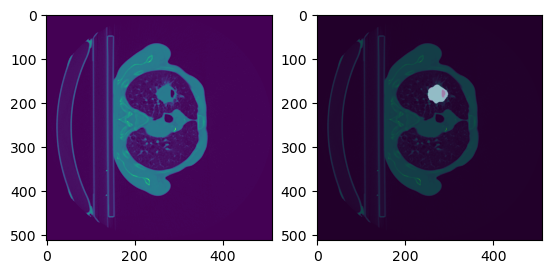

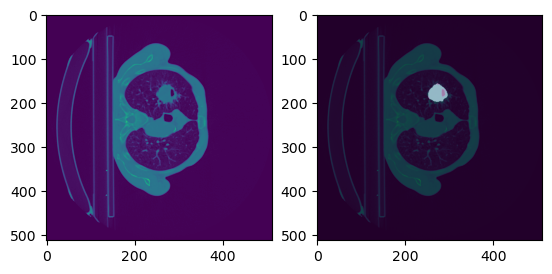

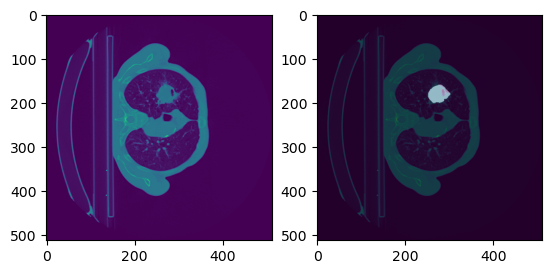

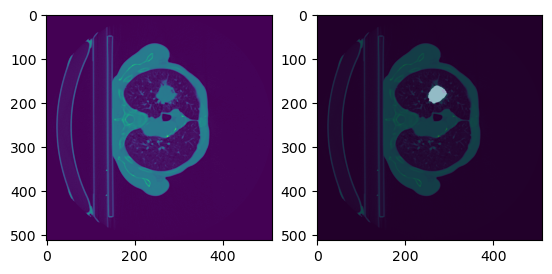

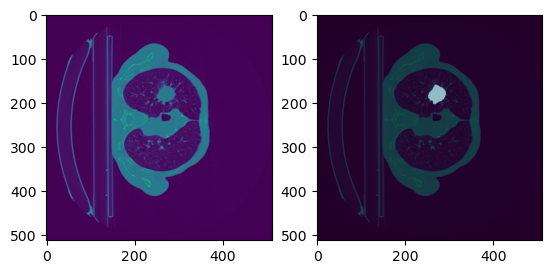

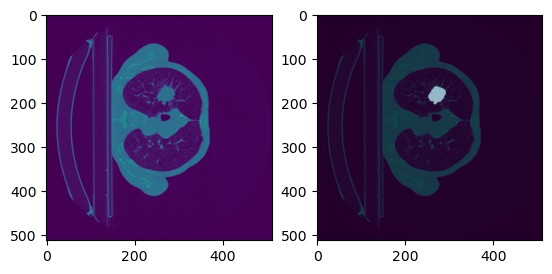

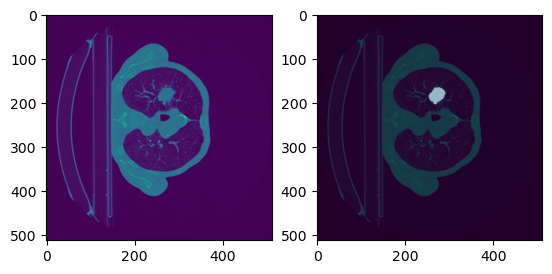

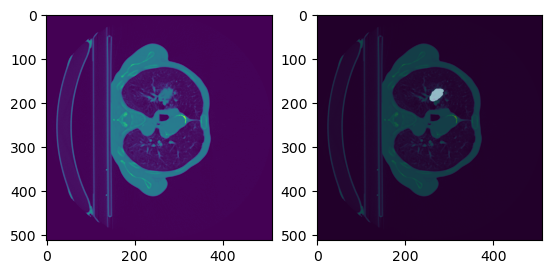

In [112]:
start, stop = get_start_stop_tumor(labels)

for l in range(start, stop):
    fig, ax = plt.subplots(1,2)
    
    ax[0].imshow(c[0, ..., l])
    ax[1].imshow(c[0, ..., l])
    ax[1].imshow(labels[0, ..., l], cmap='gray', alpha=0.5)
    plt.show()
    
    


In [113]:
from tqdm import tqdm
import pydicom

In [115]:
train_dataset[i]['seg']

'/home/aimas/Desktop/Hackathon_Enfield/datasets/Rad/NSCLC-Radiomics/LUNG1-151/300/seg'

In [116]:
path_counts = {}

for i in tqdm(range(len(train_dataset))):
    img_slices = train_dataset[i]['image'].shape[-1]
    
    label_path = train_dataset[i]['seg'] + '/00000001.dcm'

    label_ds = pydicom.dcmread(label_path)
    label_slices = label_ds.pixel_array.shape[0]
    
    path_counts[i] = (img_slices, label_slices)
    if img_slices == label_slices:
        print(f'{i}: {path_counts[i]}')
        

  4%|▎         | 12/337 [00:21<09:41,  1.79s/it]

11: (176, 176)


 45%|████▌     | 152/337 [04:28<05:08,  1.67s/it]

151: (118, 118)


 61%|██████    | 206/337 [06:08<03:38,  1.67s/it]

205: (106, 106)


 74%|███████▎  | 248/337 [07:27<02:38,  1.79s/it]

247: (131, 131)


100%|██████████| 337/337 [10:20<00:00,  1.84s/it]


In [117]:
transformed = base_transform(train_dataset[11])
transformed['seg'].shape, transformed['image'].shape


(torch.Size([7, 512, 512, 176]), torch.Size([1, 512, 512, 176]))

torch.Size([7, 512, 512])


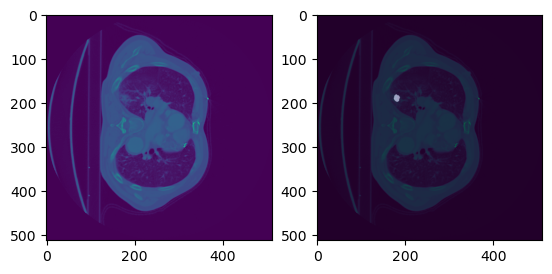

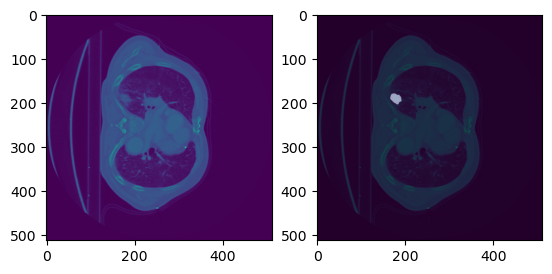

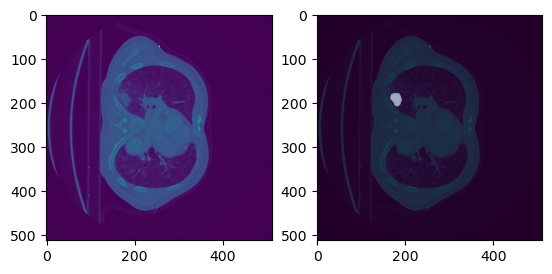

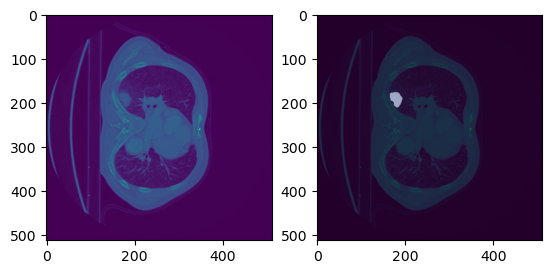

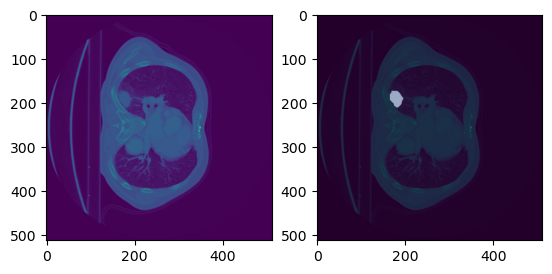

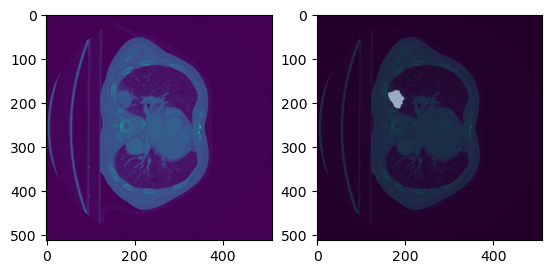

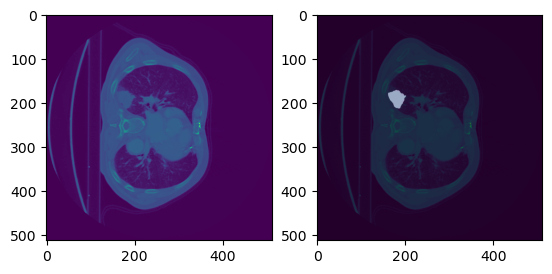

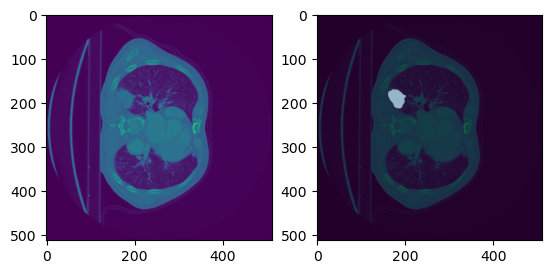

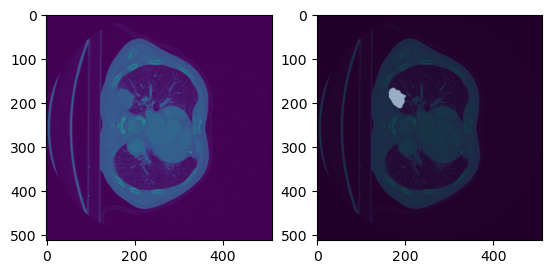

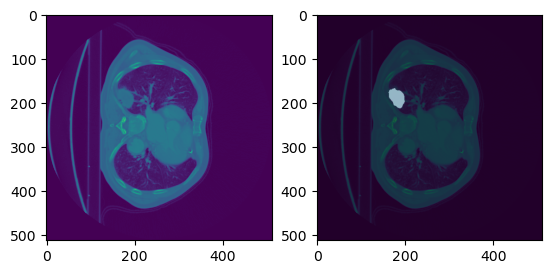

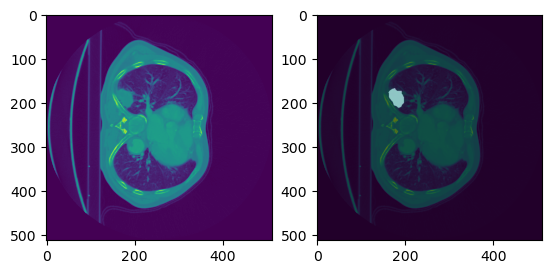

In [119]:
print(transformed['seg'][..., 0].shape)
transf_label = transformed['seg'].permute(1, 2, 3, 0)
start, stop = get_start_stop_tumor(transf_label[..., 1].unsqueeze(0))


max_images = 10

for l in range(start, stop + 1):
    if l - start > max_images:
        break
    
    fig, ax = plt.subplots(1,2)

    ax[0].imshow(transformed['image'][0,..., l])
    ax[1].imshow(transformed['image'][0,..., l])
    ax[1].imshow(transf_label[..., l, 1], cmap='gray', alpha=0.5)
    plt.show()

In [ ]:
# Patients: 11, 151, 205, 247 (image slices == label slices)

In [120]:
def get_image_and_label(data):
    transformed = base_transform(data)
    transf_label = transformed['seg'].permute(1, 2, 3, 0)
    
    return transformed['image'], transf_label[..., 1].unsqueeze(0)

In [121]:
img, label = get_image_and_label(train_dataset[0])
img.shape, label.shape

(torch.Size([1, 512, 512, 118]), torch.Size([1, 512, 512, 118]))

In [122]:
def plot_image_mask(img, mask, slc):
    fig, ax = plt.subplots(1,2)
    
    ax[0].imshow(img[0,..., slc])
    ax[1].imshow(img[0,..., slc])
    ax[1].imshow(mask[0,..., slc], cmap='gray', alpha=0.5)
    plt.show()

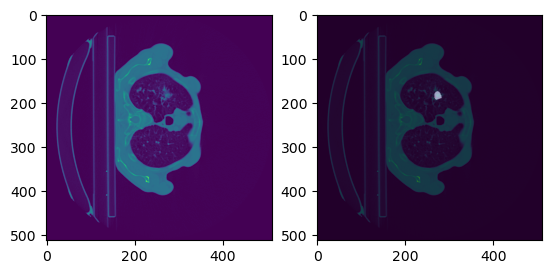

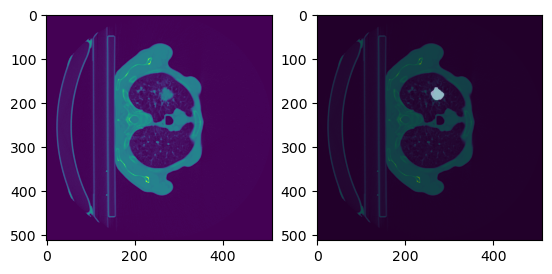

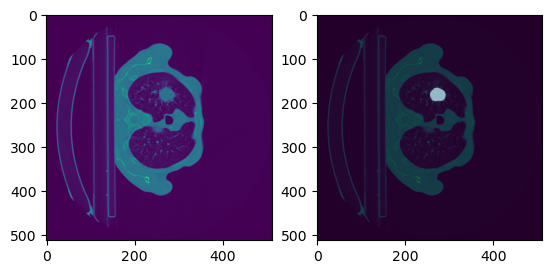

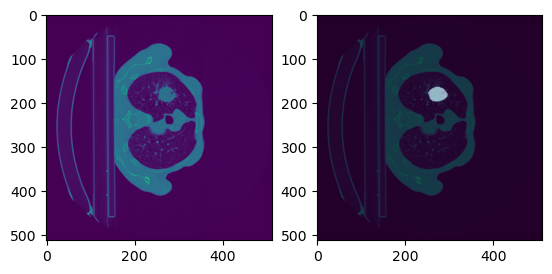

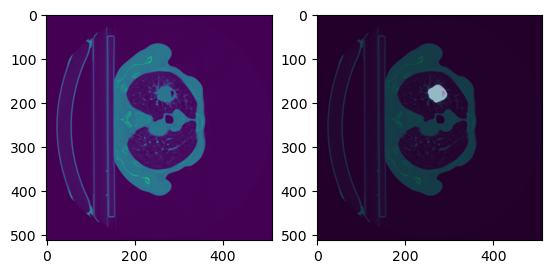

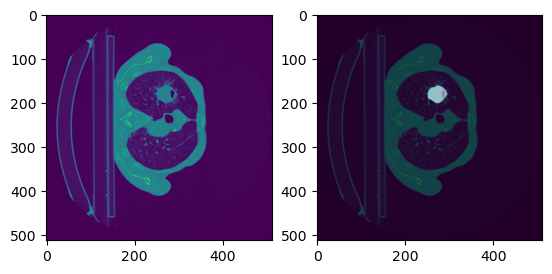

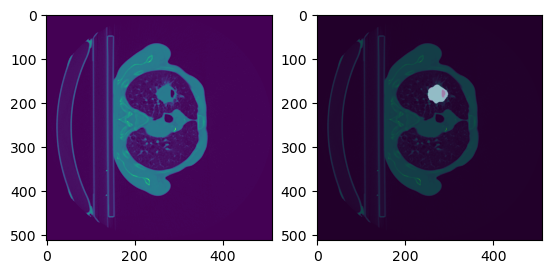

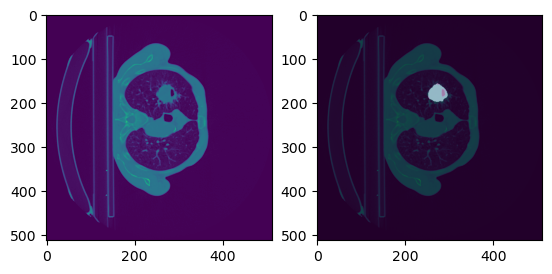

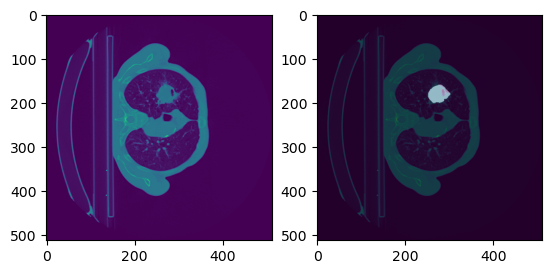

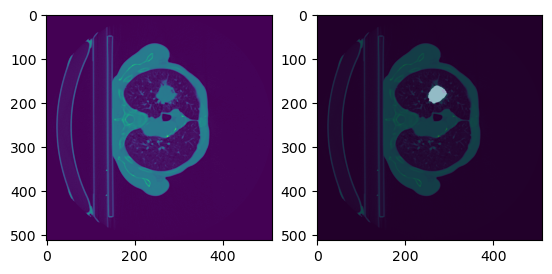

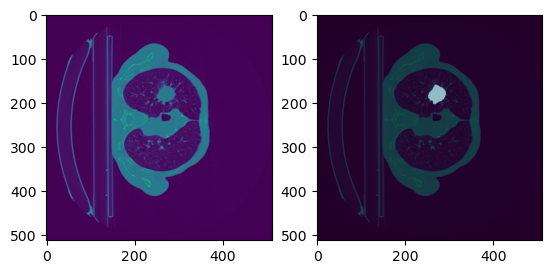

In [123]:
start, stop = get_start_stop_tumor(label)
for l in range(start, min(stop, start + 11)):
    plot_image_mask(img, label, l)

In [124]:
def get_heatmap_binning_volum(dataset, no_bins= 10):
    ## heatmap
    _, label = get_image_and_label(dataset[0])
    sample_stack = torch.zeros_like(label[0, ..., 1])     
    sample_stack = sample_stack.unsqueeze(0)
    
    for i in tqdm(range(len(dataset))):
        _, label = get_image_and_label(dataset[i])
        sample_stack += label.sum(dim=3)
        
    sample_stack = sample_stack.squeeze(0)
    
    ## binning volume
    
    binning_volume = torch.zeros(len(dataset), no_bins)
    
    for j in tqdm(range(len(dataset))):
        tumor_start = 0
        tumor_end = 0
        _, label = get_image_and_label(dataset[j])
        last_dim = label.shape[-1]
        
        for i in range(last_dim):
            mask = label[0,..., i].sum()
            if mask > 0:
                tumor_start = i
                break
        
        for i in range(last_dim):
            mask = label[0,..., last_dim - i - 1].sum()
            if mask > 0:
                tumor_end = last_dim - i - 1
                break
        
        for i in range(tumor_start, tumor_end + 1):
            idx = int(((i * 10) / last_dim))
            binning_volume[j, idx] += 1
            

    
    return sample_stack, binning_volume

In [125]:
if not os.path.exists('heatmap_binning_volume.pkl'):
    train_heatmap, train_binning = get_heatmap_binning_volum(train_dataset)
else:
    with open('heatmap_binning_volume.pkl', 'rb') as f:
        train_heatmap, train_binning = pkl.load(f)


In [126]:
height, width = train_heatmap.shape

h_min, h_max = -1, -1
w_min, w_max = -1, -1

for i in range(height):
    if np.sum(train_heatmap[i, :]) != 0:
        h_min = i
        break

for i in range(height-1, 0, -1):
    if np.sum(train_heatmap[i, :]) != 0:
        h_max = i
        break

for i in range(width):
    if np.sum(train_heatmap[:, i]) != 0:
        w_min = i
        break

for i in range(width-1, 0, -1):
    if np.sum(train_heatmap[:, i]) != 0:
        w_max = i
        break

print(f'Bounding box for tumor in 2D: (Hmin: {h_min}, Hmax: {h_max}), (Wmin: {w_min}, Wmax: {w_max})')

bbox_2d = (h_min, h_max, w_min, w_max)

Bounding box for tumor in 2D: (Hmin: 104, Hmax: 424), (Wmin: 115, Wmax: 372)


In [127]:
bbox_2d

(104, 424, 115, 372)

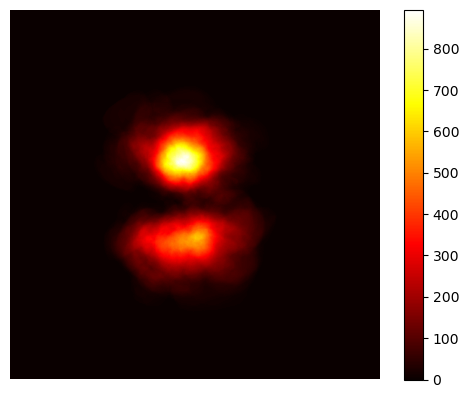

In [128]:
plt.imshow(train_heatmap, cmap='hot')
plt.axis('off')
plt.colorbar()
plt.show()

In [129]:
train_binning.shape

torch.Size([337, 10])

In [217]:
# Train_binnining: [no_patients, no_bins]

# For each patient, determine the first non-zero bin
first_non_zero_bin = []

for i in range(train_binning.shape[0]):
    non_zero_elems = np.nonzero(train_binning[i])
    first_non_zero_bin.append((i, non_zero_elems[0][0].item(), len(non_zero_elems)))
    
sorted_bins = sorted(first_non_zero_bin, key = lambda x: (x[1], x[2]))
sorted_idx = [x[0] for x in sorted_bins]
sorted_train_binning = train_binning[sorted_idx]

In [218]:
bin_with_most_tumors = np.argmax(sorted_train_binning.sum(axis=0))
bin_with_most_tumors

tensor(4)

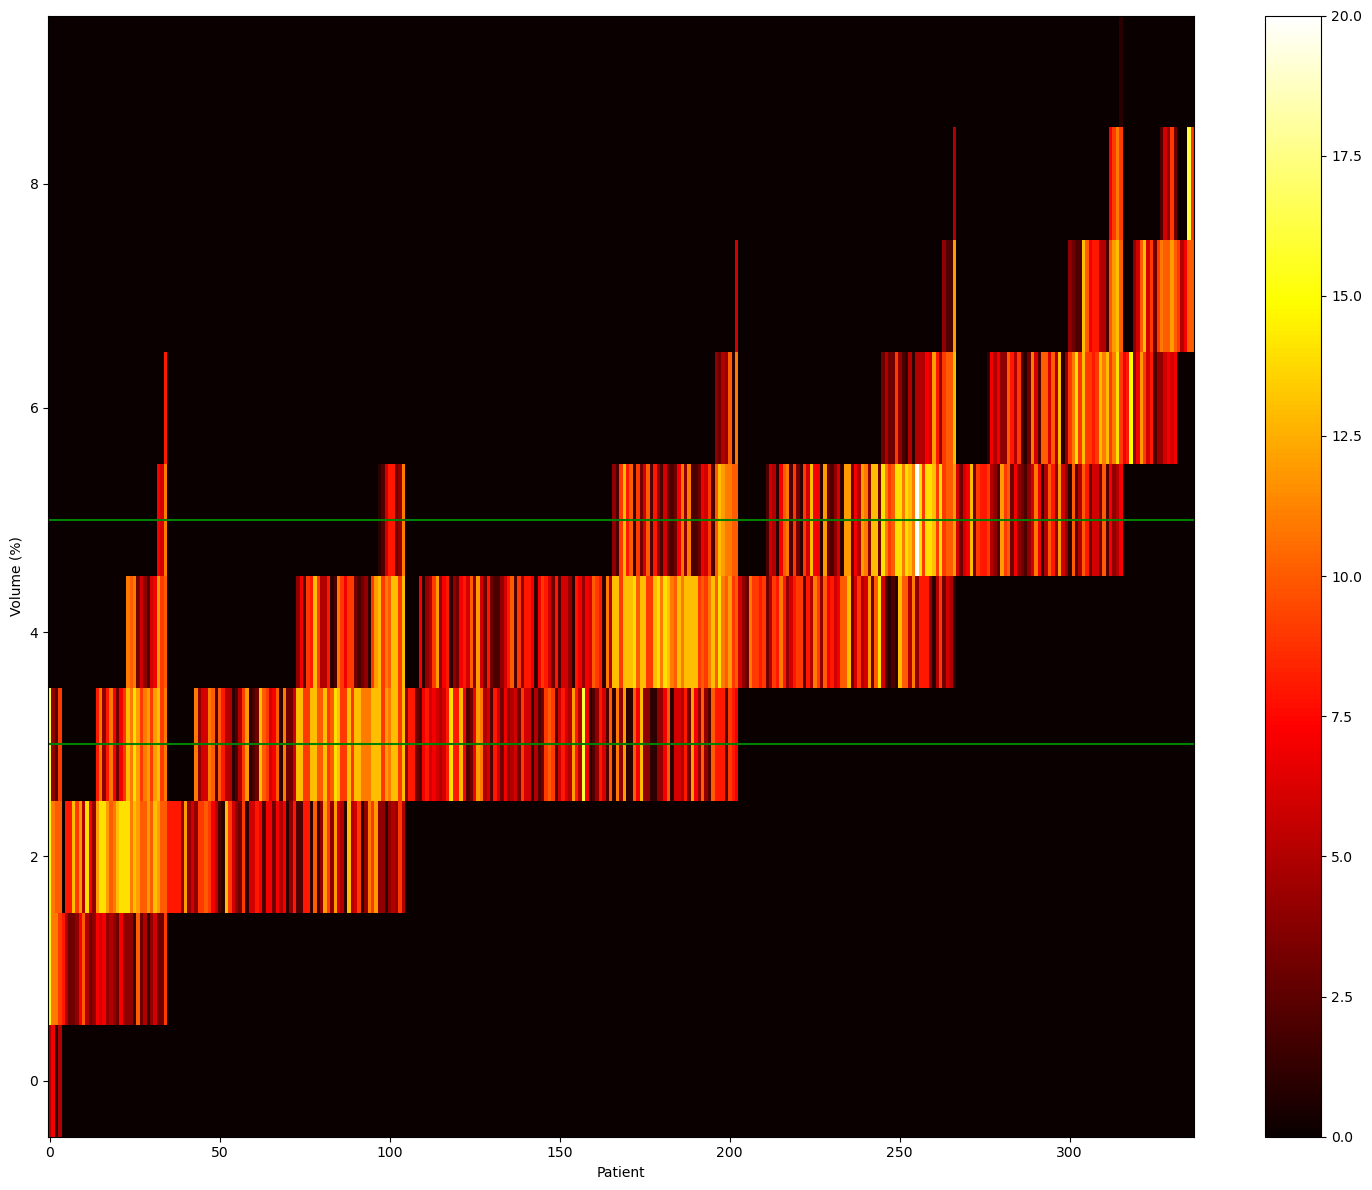

In [219]:
plt.figure(figsize=(15,12))
plt.imshow(sorted_train_binning.T, cmap='hot', aspect='auto', interpolation='nearest')
# Highlight the bin with the most tumors by plotting two horizontal green lines for the next and previous bin
plt.axhline(bin_with_most_tumors - 1, color='g', linestyle='-', markersize=3)
plt.axhline(bin_with_most_tumors + 1, color='g', linestyle='-', markersize=3)

plt.colorbar()
plt.gca().invert_yaxis()
plt.xlabel('Patient')
plt.ylabel('Volume (%)')
plt.tight_layout()
plt.show()

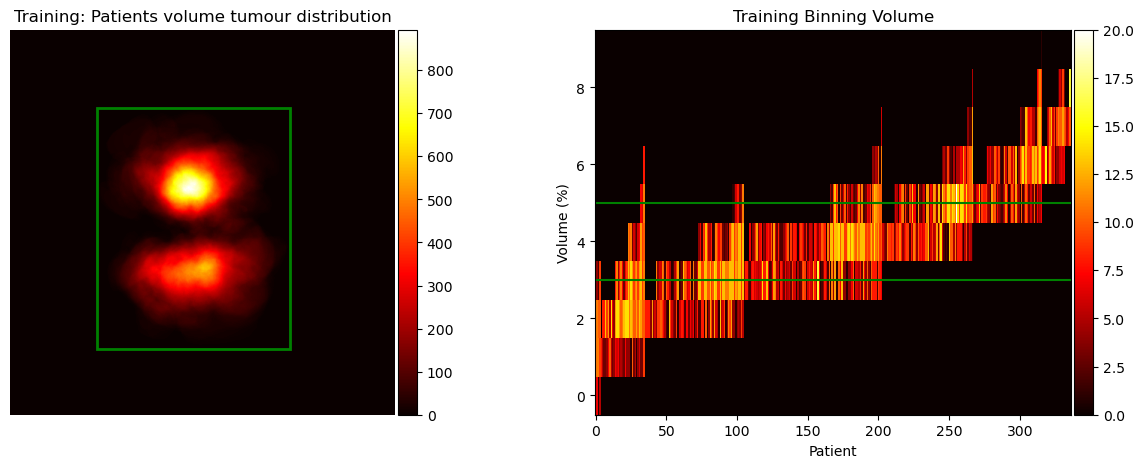

In [220]:
color = 'g'

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

img0 = axes[0].imshow(train_heatmap, cmap='hot')
# x_axis_name = f'Bounding box for tumor in 2D: (Hmin: {h_min}, Hmax: {h_max}), (Wmin: {w_min}, Wmax: {w_max})'
# axes[0].set_xlabel(x_axis_name)
axes[0].axis('off')
axes[0].set_ylabel(' ')
axes[0].set_title(f'Training: Patients volume tumour distribution')
# axes[0].colorbar()

if bbox_2d:
    h_min, h_max, w_min, w_max = bbox_2d
    axes[0].add_patch(plt.Rectangle((w_min, h_min), w_max - w_min, h_max - h_min, fill=False, edgecolor=color, lw=2))

plt.colorbar(img0, ax=axes[0], pad = 0.005)


img1 = axes[1].imshow(sorted_train_binning.T, cmap='hot', aspect='auto', interpolation='nearest')
# Highlight the bin with the most tumors by plotting two horizontal green lines for the next and previous bin
axes[1].axhline(bin_with_most_tumors - 1, color=color, linestyle='-', markersize=3)
axes[1].axhline(bin_with_most_tumors + 1, color=color, linestyle='-', markersize=3)

axes[1].invert_yaxis()
axes[1].set_xlabel('Patient')
axes[1].set_ylabel('Volume (%)')
axes[1].set_title('Training Binning Volume')

plt.colorbar(img1, ax=axes[1], pad=0.005) #fraction=0.046, 



# plt.figure(figsize=(15,12))
# plt.imshow(sorted_train_binning.T, cmap='hot', aspect='auto', interpolation='nearest')
# # Highlight the bin with the most tumors by plotting two horizontal green lines for the next and previous bin
# plt.axhline(bin_with_most_tumors - 1, color='g', linestyle='-', markersize=3)
# plt.axhline(bin_with_most_tumors + 1, color='g', linestyle='-', markersize=3)

# plt.colorbar()
# plt.gca().invert_yaxis()
# plt.xlabel('Patient')
# plt.ylabel('Volume (%)')
# plt.tight_layout()
plt.show()
